# Crypto-Assets Cointegration Project

### Modules

In [153]:
import binance_api
import numpy as np
import pandas as pd
import math

import statsmodels
from statsmodels.tsa.stattools import coint
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb
# https://www.marketcalls.in/amibroker/computing-cointegration-and-augmented-dickey-fuller-test-in-amibroker-using-python.html#:~:text=Augmented%20Dicky%20Fuller%20test%20is,stationary%20and%20cointegrated%20or%20not.&text=The%20Augmented%20Dicky%20Fuller%20test,want%20to%20reject%20this%20hypothesis.


### Default Values

In [154]:
# default values
nbr_of_coins = 30
interval = '1h'
lookback_period = 24*14
startTime = round(datetime(2021, 12, 4).timestamp()) * 1000
endTime = round(datetime(2021, 12, 19).timestamp()) * 1000

### Get coins with most volume on Binance

In [155]:
# Get all coins, sort them by volume and keep the top x nbr of coins
tickers = pd.DataFrame(binance_api.get_all_tickers())
tickers['volume_usd'] = tickers.apply(lambda row: float(row['volume']) * float(row['lastPrice']), axis=1)
tickers = tickers.sort_values(by='volume_usd', ascending=False)
top_tickers = tickers[:nbr_of_coins]

# Remove PEOPLE because its missing some data
top_tickers = top_tickers[top_tickers['symbol'] != 'PEOPLEUSDT']
#print(top_tickers['symbol'])

### Historical Data

In [156]:
historical_data = {}
for i in range(0, len(top_tickers)):
    historical_data[top_tickers.iloc[i]['symbol']] = pd.DataFrame(binance_api.get_historical_prices(top_tickers.iloc[i]['symbol'], interval, startTime, endTime))
    

In [157]:
# Data Sample
historical_data['ETHUSDT']

,0,1,2,3,4,5,6,7,8,9,10,11
0,1638594000000,4018.11,4031.54,3388.15,3842.91,941746.200,1638597599999,3558304533.89970,887402,426129.924,1610952102.58371,0
1,1638597600000,3842.54,3929.00,3787.30,3899.96,289686.495,1638601199999,1119842145.62655,348475,144486.568,558725117.86986,0
2,1638601200000,3899.79,3906.39,3816.49,3893.07,190806.579,1638604799999,738030318.10785,245724,95761.410,370528076.91788,0
3,1638604800000,3893.08,3980.00,3879.67,3938.73,159639.660,1638608399999,628183156.81330,212151,78926.965,310756657.70126,0
4,1638608400000,3938.72,3949.39,3903.96,3931.85,83101.147,1638611999999,326147834.12733,126599,41648.602,163476236.84735,0
...,...,...,...,...,...,...,...,...,...,...,...,...
356,1639875600000,3940.93,3953.14,3881.89,3901.76,70240.204,1639879199999,274923069.93284,89190,32192.300,126029308.70785,0
357,1639879200000,3901.76,3946.84,3896.33,3940.97,58026.232,1639882799999,227827981.13030,72608,32412.335,127222391.86483,0
358,1639882800000,3940.97,4034.99,3940.61,3987.73,145766.032,1639886399999,582097772.40543,176773,80807.014,322614906.82132,0
359,1639886400000,3987.73,4024.42,3987.21,4007.91,48453.638,1639889999999,194097291.29960,68357,26188.054,104912079.87016,0


### Cointegration Example

In [158]:
data_1 = np.asarray(historical_data['BTCUSDT'][4].tail(lookback_period)).astype(float)
data_2 = np.asarray(historical_data['ETHUSDT'][4].tail(lookback_period)).astype(float)
result = stat.OLS(data_1, data_2).fit()
a = ts.adfuller(result.resid)
print('p-value: {}'.format(a[1]))

p-value: 0.513621631567219


### Cointegration Matrix

<AxesSubplot:>

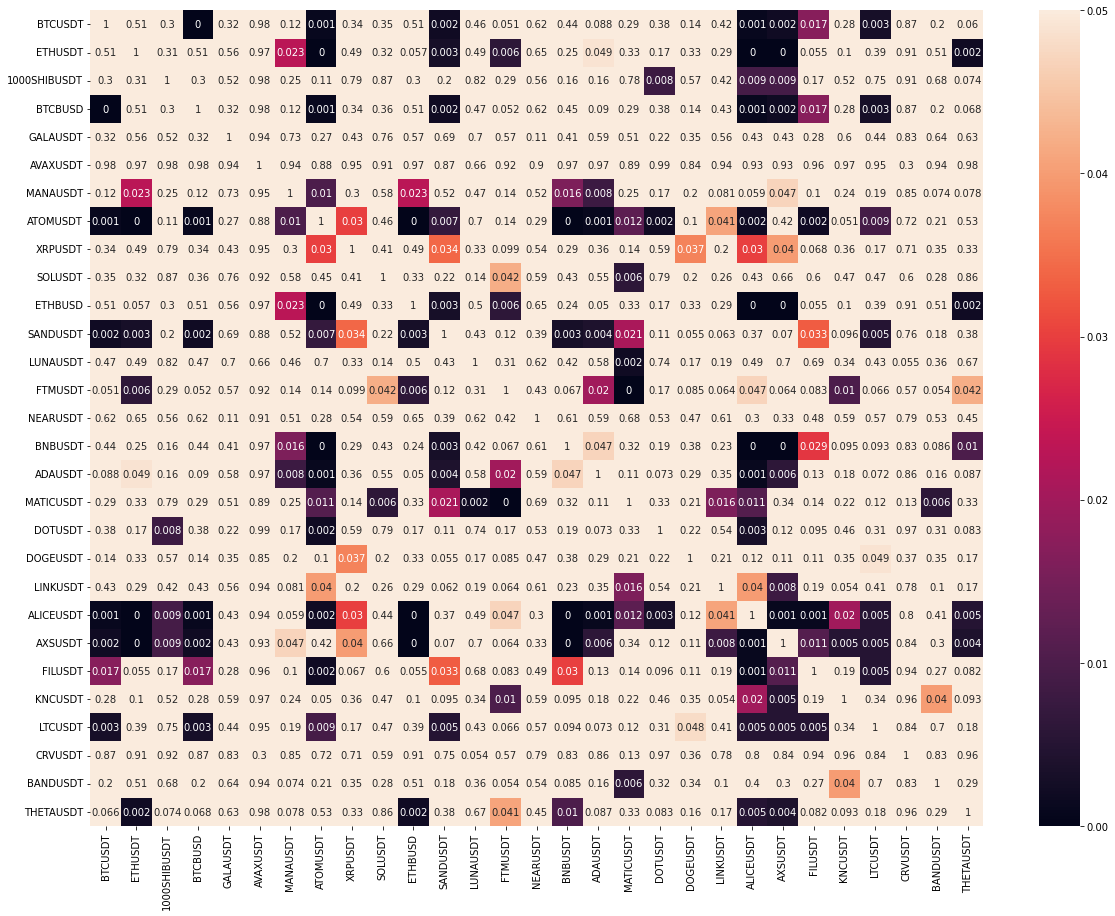

In [159]:
symbols = list(historical_data.keys())
coint_matrix = pd.DataFrame(index=symbols, columns=symbols)

for i in range(0, len(coint_matrix)):
    for j in range(0, len(coint_matrix)):
        if i != j:
            #print('{},{}'.format(i,j))
            data_1 = np.asarray(historical_data[coint_matrix.index[i]][4].tail(lookback_period)).astype(float)
            data_2 = np.asarray(historical_data[coint_matrix.index[j]][4].tail(lookback_period)).astype(float)
            if len(data_1) == len(data_2):
                result = stat.OLS(data_1, data_2).fit()
                a = ts.adfuller(result.resid)
                pvalue = a[1]
                coint_matrix[coint_matrix.index[i]][coint_matrix.index[j]] = round(pvalue, 3)

# Color cells accordingly
coint_matrix.style.applymap(lambda x: "background-color: red" if x>0.1 else "background-color: green")

coint_matrix = coint_matrix.fillna(1)

# Show
plt.figure(figsize=(20,15))
sb.heatmap(coint_matrix, annot=True, vmin=0, vmax=0.05)

In [160]:
# Stats
nbr_of_cointegrated_pairs = coint_matrix[coint_matrix < 0.05].count().sum() / 2
nbr_of_pairs = coint_matrix.size / 2
percentage_of_cointegration = nbr_of_cointegrated_pairs / nbr_of_pairs * 100
print('{:.2f}% of the most liquid pairs are cointegrated'.format(percentage_of_cointegration))

20.69% of the most liquid pairs are cointegrated


## % of cointegrated pairs over time

In [161]:
# We have to do a rolling window
periodStart = round(datetime(2021, 6, 1).timestamp()) * 1000
periodEnd = round(datetime(2021, 12, 31).timestamp()) * 1000

